In [536]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    BaggingClassifier,
    VotingClassifier,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier


from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay,
)

from scipy.stats import boxcox
from imblearn.over_sampling import SMOTE


dont_panic = 42

# Section 1 Load and inspect the data

In [537]:
# Load the dataset (download from UCI and save in the same folder)
df = pd.read_csv("../data/winequality-red.csv", sep=";")

# Display structure and first few rows
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [538]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [539]:
# The dataset includes 11 physicochemical input variables (features):
# ---------------------------------------------------------------
# - fixed acidity          mostly tartaric acid
# - volatile acidity       mostly acetic acid (vinegar)
# - citric acid            can add freshness and flavor
# - residual sugar         remaining sugar after fermentation
# - chlorides              salt content
# - free sulfur dioxide    protects wine from microbes
# - total sulfur dioxide   sum of free and bound forms
# - density                related to sugar content
# - pH                     acidity level (lower = more acidic)
# - sulphates              antioxidant and microbial stabilizer
# - alcohol                % alcohol by volume

# The target variable is:
# - quality (integer score from 0 to 10, rated by wine tasters)

# We will simplify this target into three categories:
#   - low (3–4), medium (5–6), high (7–8) to make classification feasible.
#   - we will also make this numeric (we want both for clarity)
# The dataset contains 1599 samples and 12 columns (11 features + target).

In [540]:
# Check for duplicate rows in the dataset
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 240


In [541]:
# Drop duplicate rows from the dataframe
df = df.drop_duplicates()

# Verify the number of rows after dropping duplicates
print(f"Number of rows after dropping duplicates: {len(df)}")

Number of rows after dropping duplicates: 1359


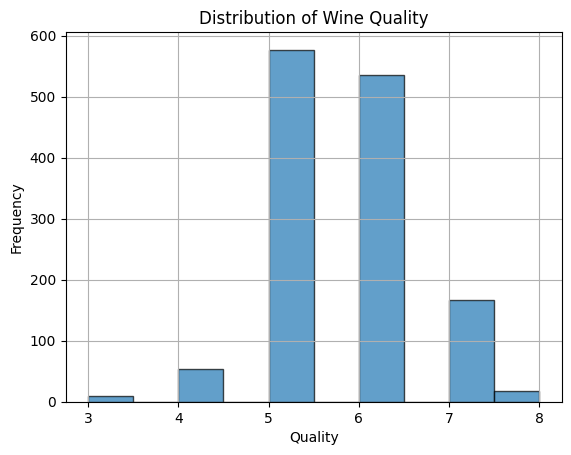

In [542]:
# Create a histogram of the 'quality' column
df['quality'].hist(bins=10, edgecolor='black', alpha=0.7)
plt.title('Distribution of Wine Quality')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.show()

The first concern here is the data itself.  The bulk of the quality ratings are either 5 or 6.  With so few <=4 and >6 ratings, it is going to present a challenge for the modl.

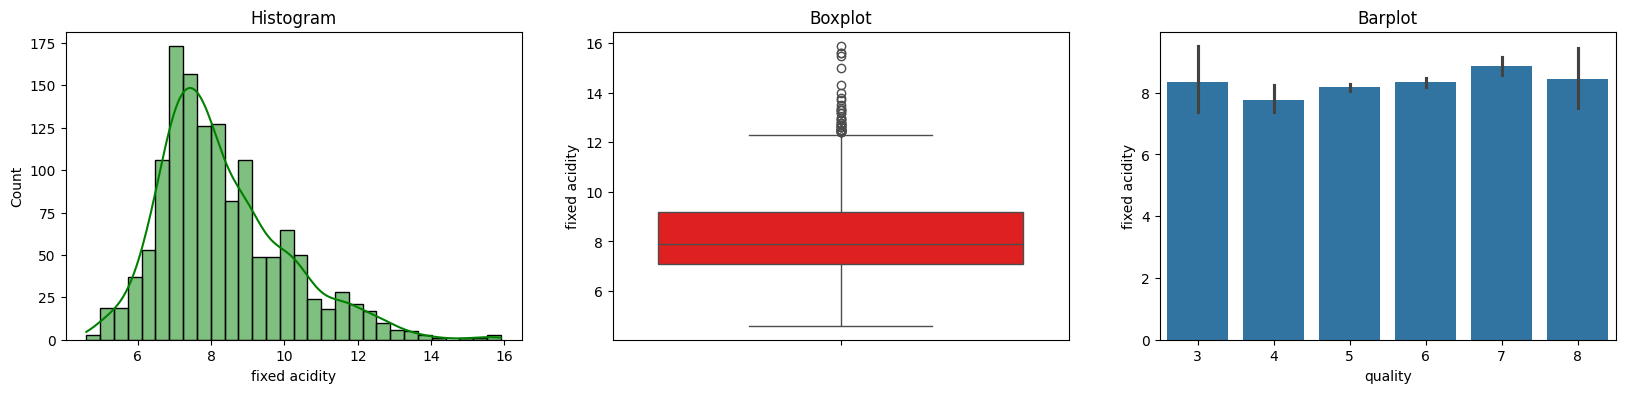

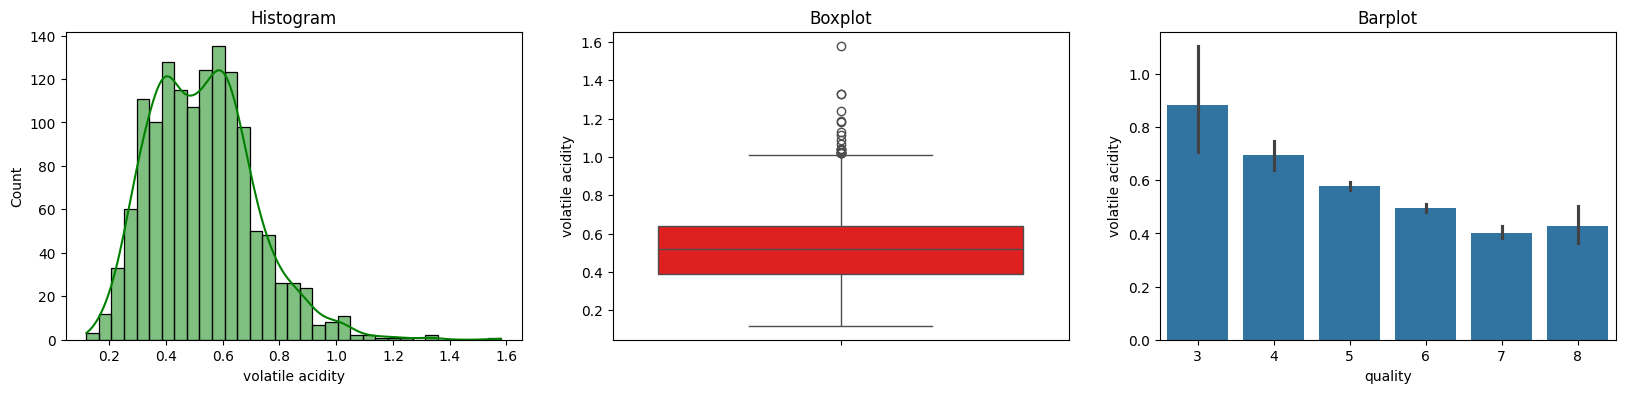

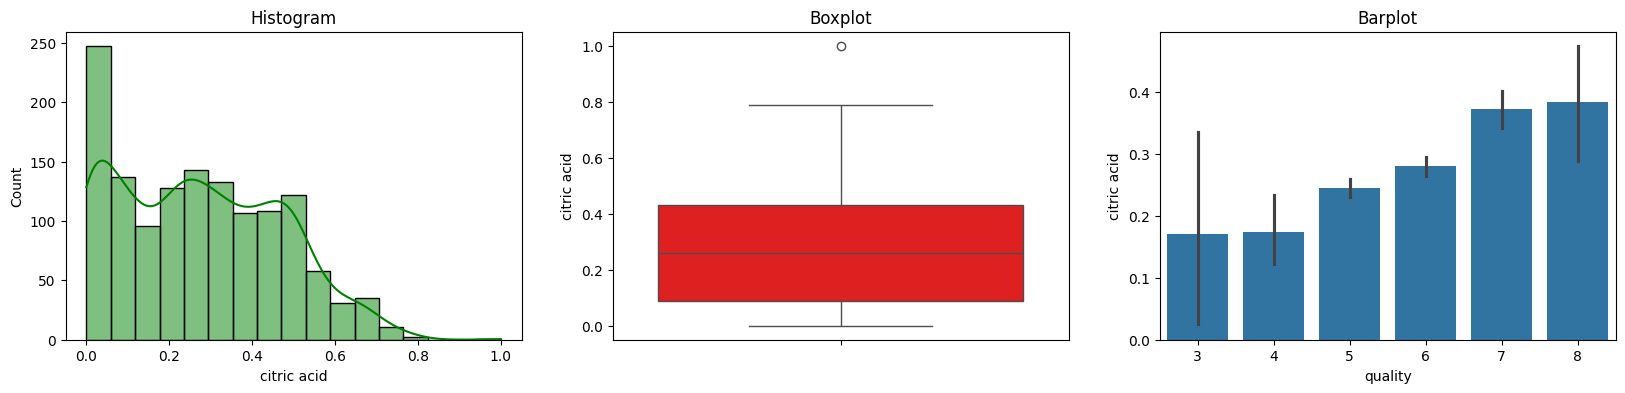

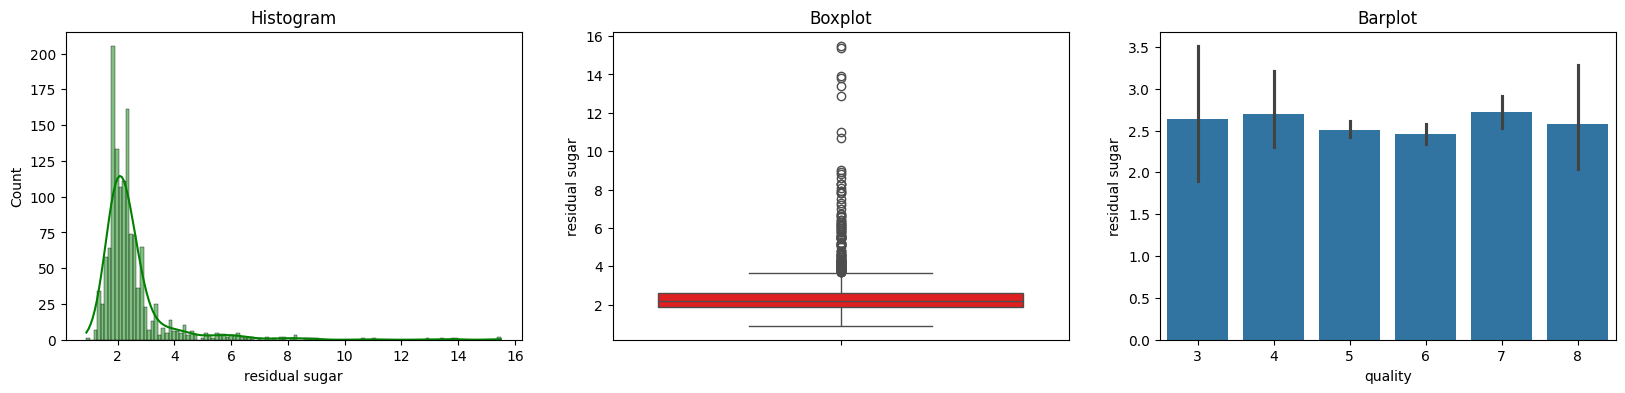

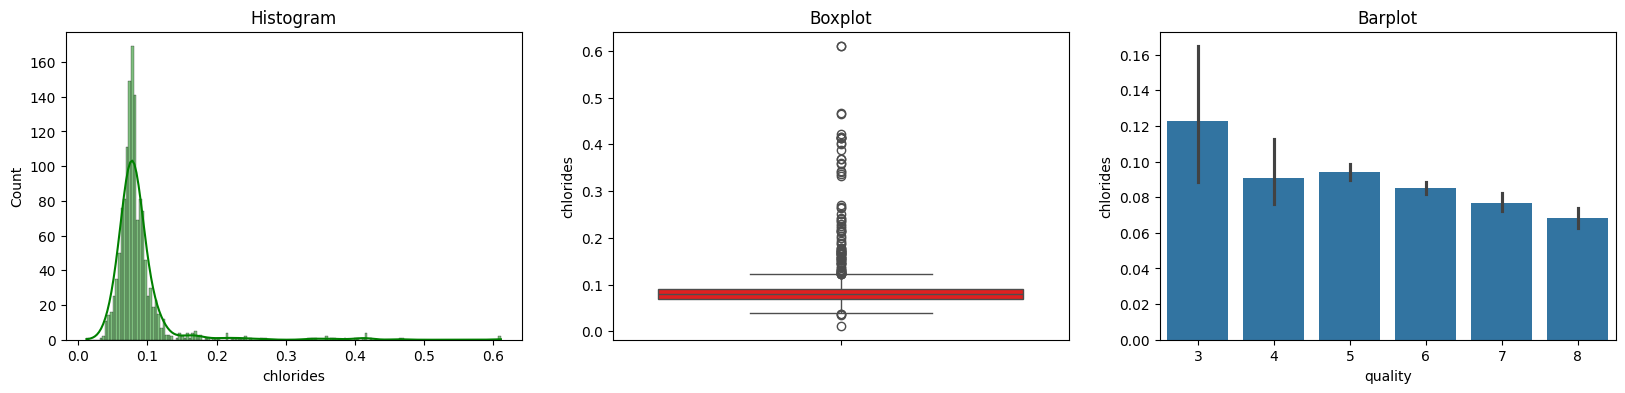

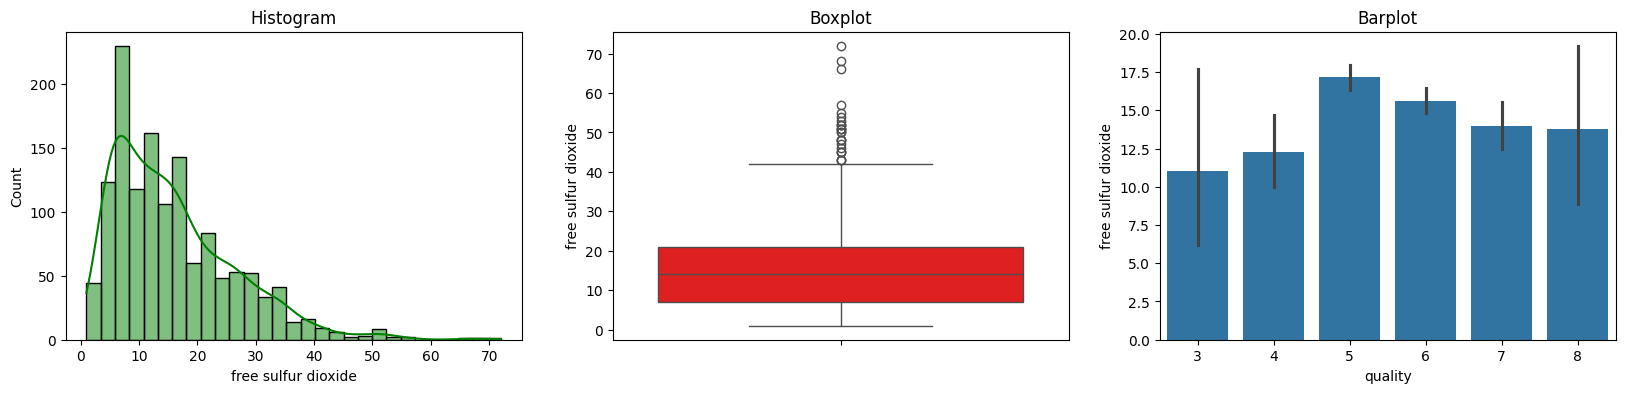

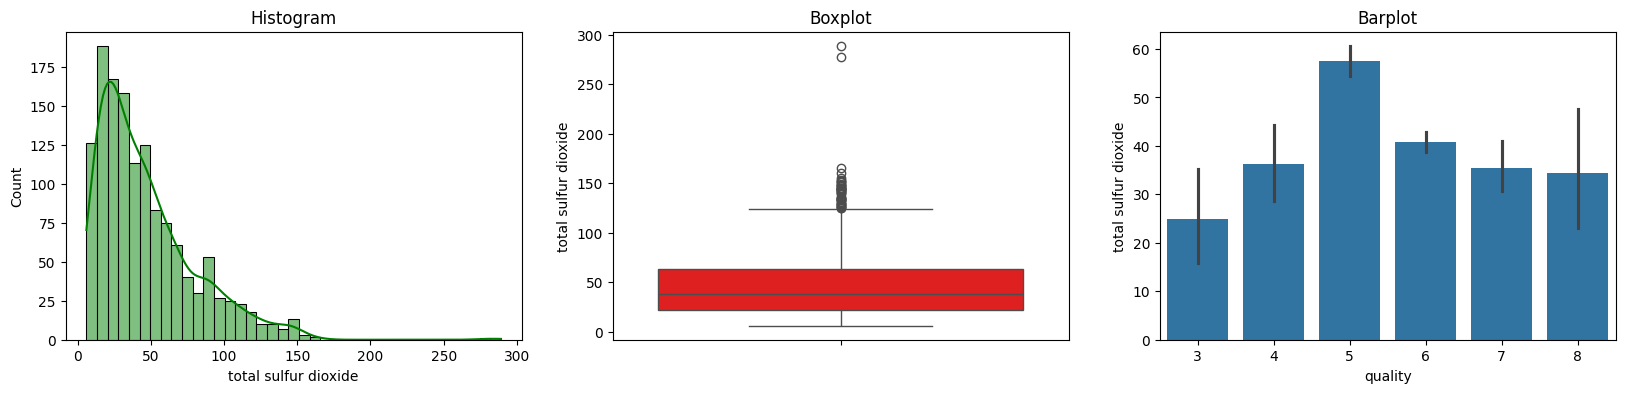

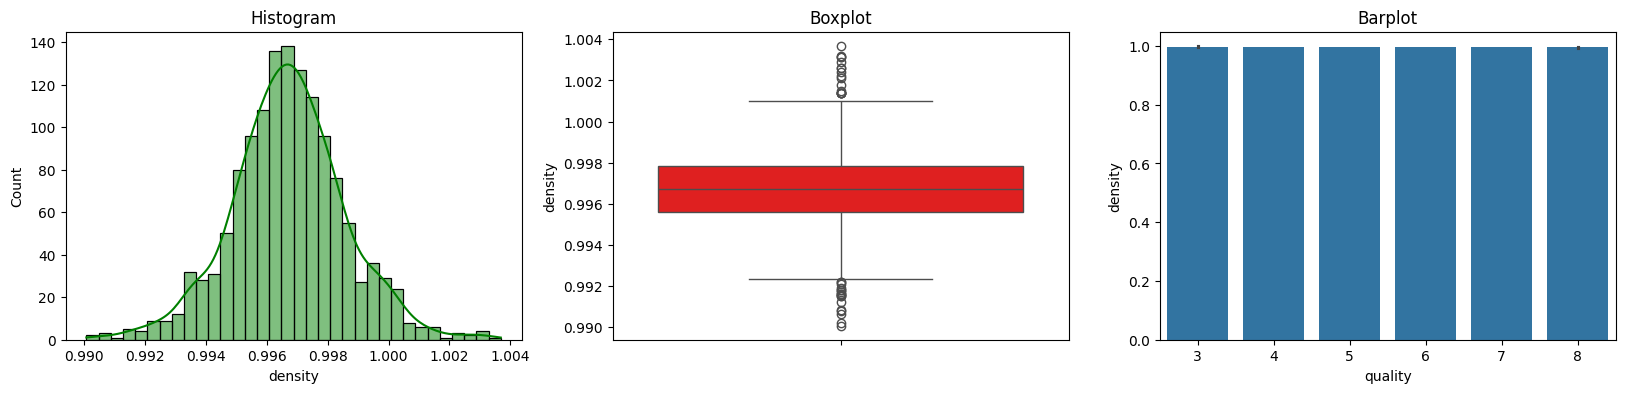

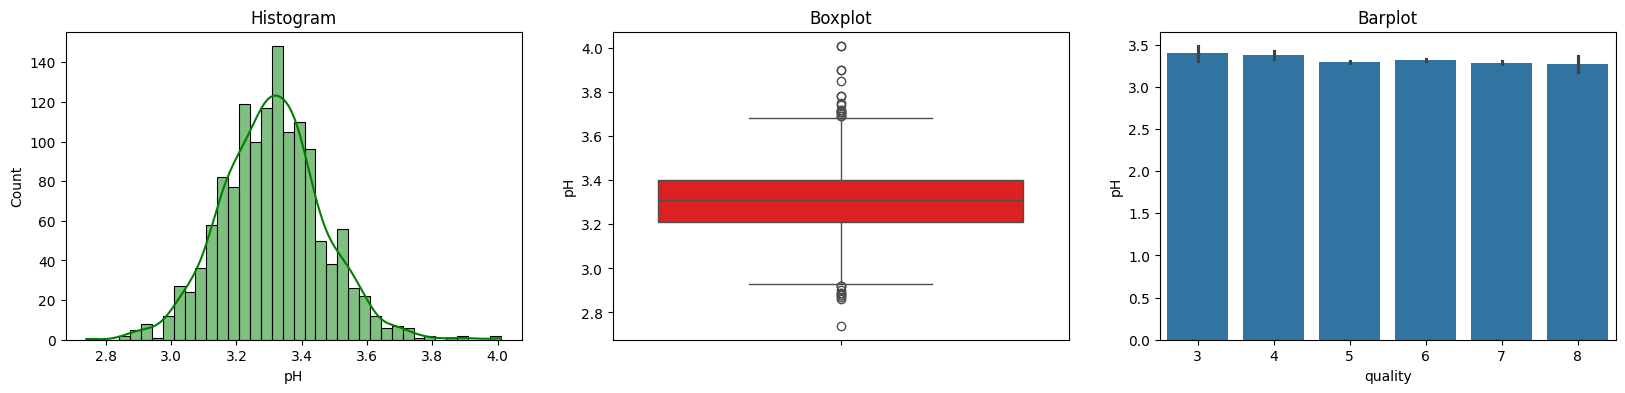

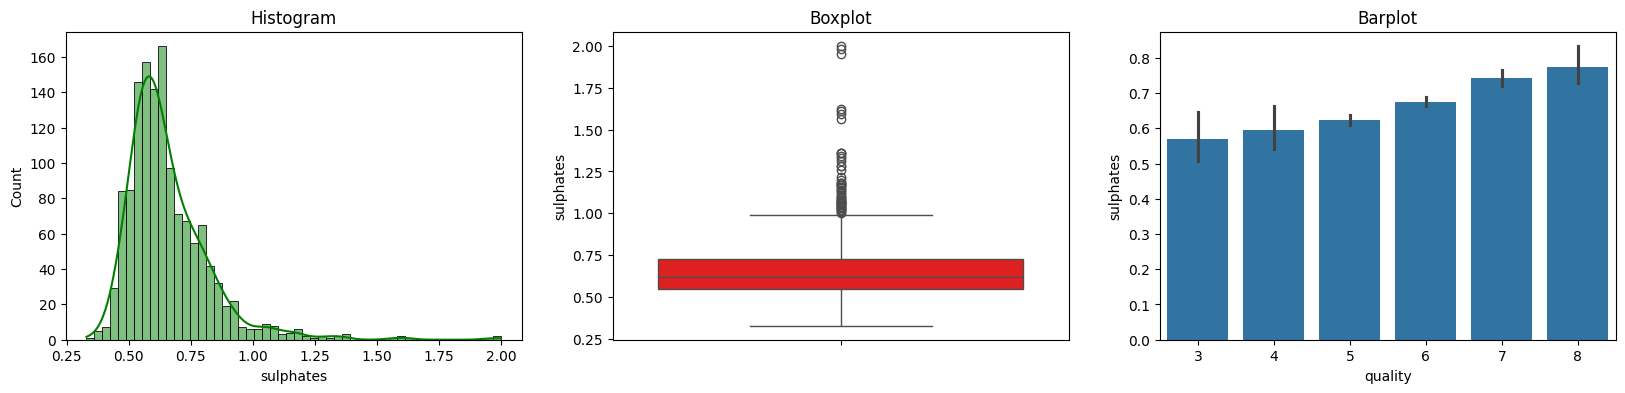

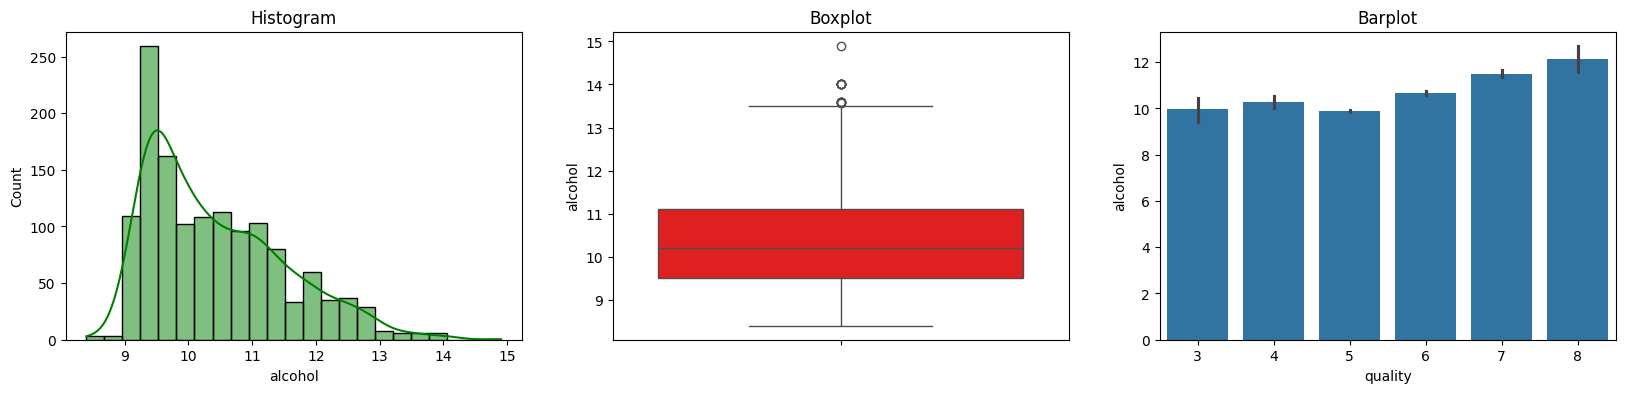

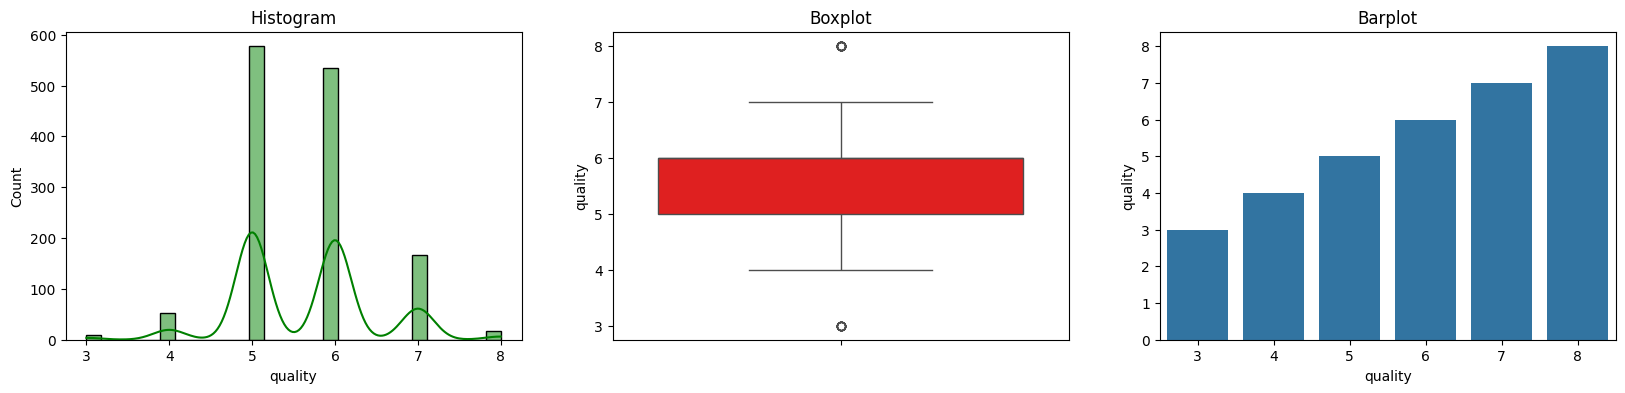

In [543]:
def multiple_plots(df, variable,target):
    # The function takes a dataframe (df) and
    # the variable of interest as arguments.

    # Define figure size.
    plt.figure(figsize=(20, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], kde = True,color='g')
    plt.title('Histogram')
    
    # boxplot
    plt.subplot(1, 3, 2)
    sns.boxplot(y=df[variable],color = 'r')
    plt.title('Boxplot')
    
    # barplot
    plt.subplot(1, 3, 3)
    sns.barplot(x = target, y = variable, data = df)   
    plt.title('Barplot')
    
    
    plt.show()

for col in df:
    multiple_plots(df,col,'quality')

Some of these features are normally distributed (e.g. density, and pH)  Others demonstrate right skew.

 - Fixed acidity doesn't seem to vary much across the ratings.  Could this be dropped?
 - Volatile acidity decreases with rating; however, theres a lot of variability at 3
 - citric acid increases with rating.  There is a lot of variability at 3 and 8
 - residual sugar, like fixed acidity, doesn't vary much across the ratings.  There is a lot of variability at ratings 3, 4, and 8
 - Chlorides decreases with rating; however, there's a lot of variability at ratings 3 and 4
 - free sulfur dioxide peaks at quality of 5; however, there's a lot of variability in this feature at ratings 3 and 8
 - Total sulfur dioxide also peaks at 5.  Could this be redundant with free sulfur dioxide?
 - density and pH are normally distributed.  There is not much change between the different quality levels.  pH maybe slightly decreaes with rating.
 - sulphates increases with rating.  There is more variability at ratings 3 and 8
 - alcohol increases with rating.  There is more variability at ratings 3 and 8

What does this tell us?  There is a lot more variability in these features at the extremes of the ratings than in the middle.  

# Section 2 Prepare the Data

In [544]:
# Define helper function that:

# Takes one input, the quality (which we will temporarily name q while in the function)
# And returns a string of the quality label (low, medium, high)
# This function will be used to create the quality_label column
def quality_to_label(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"


# Call the apply() method on the quality column to create the new quality_label column
df["quality_label"] = df["quality"].apply(quality_to_label)


# Then, create a numeric column for modeling: 0 = low, 1 = medium, 2 = high
def quality_to_number(q):
    if q <= 4:
        return 0
    elif q <= 6:
        return 1
    else:
        return 2


df["quality_numeric"] = df["quality"].apply(quality_to_number)

# Explain what we do and why as you proceed. 
df.head(10)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_label,quality_numeric
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,medium,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,medium,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,medium,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,medium,1
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,medium,1
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5,medium,1
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7,high,2
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7,high,2
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5,medium,1
10,6.7,0.58,0.08,1.8,0.097,15.0,65.0,0.9959,3.28,0.54,9.2,5,medium,1


In [545]:
 # an experiment to see if binary classification is better
# This function will be used to create the quality_label column
#def quality_to_label(q):
#    if q <= 6:
#        return "ok"
#    else:
#        return "excellent"


# Call the apply() method on the quality column to create the new quality_label column
#df["quality_label"] = df["quality"].apply(quality_to_label)


# Then, create a numeric column for modeling: 0 = low, 1 = medium, 2 = high
#def quality_to_number(q):
#    if q <= 6:
#        return 0
#    else:
#        return 1


#df["quality_numeric"] = df["quality"].apply(quality_to_number)

# Explain what we do and why as you proceed. 
#df.head(10)


In [546]:
# List of features to transform
features_to_transform = [
    "alcohol",
    "sulphates",
    "total sulfur dioxide",
    "free sulfur dioxide",
    "chlorides",
    "residual sugar",
    "citric acid",
    "volatile acidity",
    "fixed acidity",
]

# Apply Box-Cox transformation
#for feature in features_to_transform:
    # Ensure all values are positive by adding a small constant if necessary
#    if (df[feature] <= 0).any():
#        df[feature] += 1e-6
#    df[feature], _ = boxcox(df[feature])

# Apply log transformation
for feature in features_to_transform:
    # Ensure all values are positive by adding a small constant if necessary
    if (df[feature] <= 0).any():
        df[feature] += 1e-6
    df[feature] = np.log(df[feature])

# Display the transformed dataframe
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_label,quality_numeric
0,2.001480,-0.356675,-13.815511,0.641854,-2.577022,2.397895,3.526361,0.9978,3.51,-0.579818,2.240710,5,medium,1
1,2.054124,-0.127833,-13.815511,0.955511,-2.322788,3.218876,4.204693,0.9968,3.20,-0.385662,2.282382,5,medium,1
2,2.054124,-0.274437,-3.218851,0.832909,-2.385967,2.708050,3.988984,0.9970,3.26,-0.430783,2.282382,5,medium,1
3,2.415914,-1.272966,-0.579817,0.641854,-2.590267,2.833213,4.094345,0.9980,3.16,-0.544727,2.282382,6,medium,1
5,2.001480,-0.415515,-13.815511,0.587787,-2.590267,2.564949,3.688879,0.9978,3.51,-0.579818,2.240710,5,medium,1


In [547]:

# Exclude the columns 'quality', 'quality_numeric', and 'quality_label'
#columns_to_transform = df.drop(columns=["quality", "quality_numeric", "quality_label"]).columns

# Create a PolynomialFeatures object for degree 3
#poly = PolynomialFeatures(degree=3, include_bias=False)

# Transform the features
#poly_features = poly.fit_transform(df[columns_to_transform])

# Get the names of the new polynomial features
#poly_feature_names = poly.get_feature_names_out(columns_to_transform)

# add the poly features to the dataframe
#df_poly = pd.DataFrame(poly_features, columns=poly_feature_names)
# Concatenate the original dataframe with the polynomial features
#df = pd.concat([df, df_poly], axis=1)



In [548]:
df['quality_label'].value_counts()

quality_label
medium    1112
high       184
low         63
Name: count, dtype: int64

# Section 3 Feature Selections and Justification

In [549]:
# Define input features (X) and target (y)
# Features: all columns except 'quality' and 'quality_label' and 'quality_numberic' - drop these from the input array
# Target: quality_label (the new column we just created)
X = df.drop(columns=["quality", "quality_label", "quality_numeric"])  # Features
y = df["quality_numeric"]  # Target

# Section 4 Split the data into training and test sets

In [550]:
# Train/test split (stratify to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=dont_panic, stratify=y
)

In [551]:
# Resample the training data using SMOTE
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# X_train, y_train = X_train_resampled, y_train_resampled

# Display the class distribution after resampling
# print("Class distribution after SMOTE resampling:")
# print(y_train_resampled.value_counts())

# Section 5 Evaluate Model Performance

In [552]:
# Helper function to train and evaluate models
def evaluate_model(name, model, X_train, y_train, X_test, y_test, results):
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred, average="weighted")
    test_f1 = f1_score(y_test, y_test_pred, average="weighted")
    train_precision = precision_score(y_train, y_train_pred, average="weighted")
    test_precision = precision_score(y_test, y_test_pred, average="weighted")
    train_recall = recall_score(y_train, y_train_pred, average="weighted")
    test_recall = recall_score(y_test, y_test_pred, average="weighted")

    print(f"\n{name} Results")
    print("Confusion Matrix (Test):")
    print(confusion_matrix(y_test, y_test_pred))
    print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
    print(f"Train F1 Score: {train_f1:.4f}, Test F1 Score: {test_f1:.4f}")
    print(f"Train Precision: {train_precision:.4f}, Test Precision: {test_precision:.4f}")
    print(f"Train Recall: {train_recall:.4f}, Test Recall: {test_recall:.4f}")

    results.append(
        {
            "Model": name,
            "Train Accuracy": train_acc,
            "Test Accuracy": test_acc,
            "Train F1": train_f1,
            "Test F1": test_f1,
            "Train Precision": train_precision,
            "Test Precision": test_precision,
            "Train Recall": train_recall,
            "Test Recall": test_recall,
            "Confusion Matrix": confusion_matrix(y_test, y_test_pred),
        }
    )
    
# Here's how to create the different types of ensemble models listed above (you don't need to do all of them yourself. Choose 2 - we have a whole team working on this.)

results = []

# 1. AdaBoost 
evaluate_model(
    "AdaBoost (100)",
    AdaBoostClassifier(n_estimators=100, random_state=dont_panic),
    X_train,
    y_train,
    X_test,
    y_test,
    results,
)

# 2. Gradient Boosting
evaluate_model(
    "Gradient Boosting (100)",
    GradientBoostingClassifier(
        n_estimators=100, learning_rate=0.005, max_depth=4, random_state=dont_panic
    ),
    X_train,
    y_train,
    X_test,
    y_test,
    results,
)



AdaBoost (100) Results
Confusion Matrix (Test):
[[  1  12   0]
 [  4 201  17]
 [  0  14  23]]
Train Accuracy: 0.8261, Test Accuracy: 0.8272
Train F1 Score: 0.8117, Test F1 Score: 0.8173
Train Precision: 0.8034, Test Precision: 0.8105
Train Recall: 0.8261, Test Recall: 0.8272

Gradient Boosting (100) Results
Confusion Matrix (Test):
[[  0  13   0]
 [  0 222   0]
 [  0  36   1]]
Train Accuracy: 0.8206, Test Accuracy: 0.8199
Train F1 Score: 0.7416, Test F1 Score: 0.7422
Train Precision: 0.8069, Test Precision: 0.8046
Train Recall: 0.8206, Test Recall: 0.8199


/home/philip/nwmissouri/applied-ml-philip/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/philip/nwmissouri/applied-ml-philip/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Section 6 Compare Results

In [553]:
# Create a table of results 
results_df = pd.DataFrame(results)

print("\nSummary of All Models:")
display(results_df)


Summary of All Models:


,Model,Train Accuracy,Test Accuracy,Train F1,Test F1,Train Precision,Test Precision,Train Recall,Test Recall,Confusion Matrix
0,AdaBoost (100),0.826127,0.827206,0.811675,0.817316,0.803363,0.810469,0.826127,0.827206,"[[1, 12, 0], [4, 201, 17], [0, 14, 23]]"
1,Gradient Boosting (100),0.820607,0.819853,0.741557,0.742215,0.806850,0.804632,0.820607,0.819853,"[[0, 13, 0], [0, 222, 0], [0, 36, 1]]"


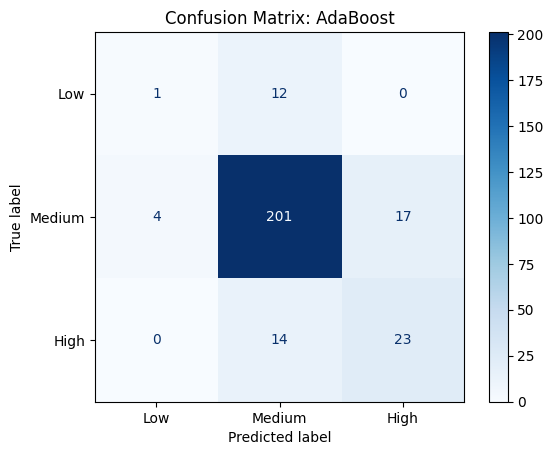

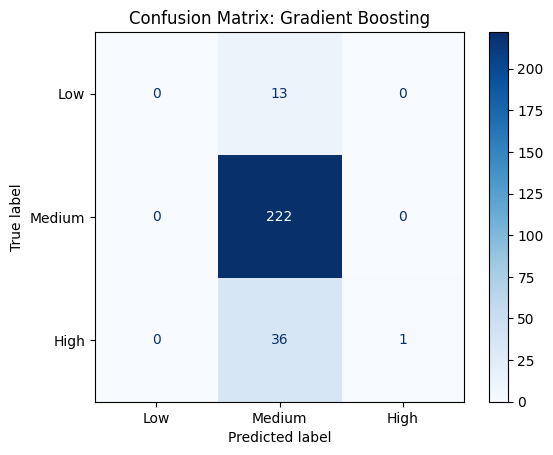

In [554]:
# Function to plot confusion matrix
def plot_confusion_matrix_from_results(conf_matrix, title):
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Low", "Medium", "High"])
    disp.plot(cmap="Blues")
    plt.title(title)
    plt.show()

# Extract confusion matrices from results_df
ada_conf_matrix = results_df.loc[0, "Confusion Matrix"]
grad_boost_conf_matrix = results_df.loc[1, "Confusion Matrix"]

# Plot confusion matrix for AdaBoost
plot_confusion_matrix_from_results(ada_conf_matrix, "Confusion Matrix: AdaBoost")

# Plot confusion matrix for Gradient Boosting
plot_confusion_matrix_from_results(grad_boost_conf_matrix, "Confusion Matrix: Gradient Boosting")


# Section 7 Conclusions and Insights

## Things I tried
With the initial settings of Adaboost n_estimators=100 and Gradient Boost n_estimators=100, learning_rate=0.1, max_depth=3, both models overfitted as seen by the train vs test accuracy.  The adaboost model is only slightly overfitting; whereas the gradient boost model is overfitting by much more.  The biggest problem that I see is that the target is very imbalanced.  There are only 63 low quality and 217 high quality labels; while there are 1319 medium.  

My first effort at improving this was to transform the right skewed features using box-cox transform.  This lowered the test accuracy for gradient boosting from 0.8562 to 0.8531

My next effort at improving this was to create polynomial features.  This improved the test accuracy for gradient boosting from 0.8531 to 0.8559.  

I also tried the polynomial features without the box cox transformation.  This lowered the Adaboost accuracy from 0.8342 to 0.7813.  However, gradient boosting's accuracy went up to 0.8781.  Not much of an 

Next step.  More EDA to see if I can figure out which features I should pay attention to.  Maybe I can feature engineer them in some way.

My next effort was to change the prediction from low medium high to good and bad.  Good was >4 and bad was <=4.  This improved the test accuracy.  However, notice that the confusion matrices only show a single case of bad wine being correctly predicted.  I suspect that we need a lot more examples of bad wine to make this work.

I tried this again with ok wine as <=6 and excellent wine as >6  There were almost twice as many false negatives as there were true positives.  Likewise, there were nearly as many false positives as true positives.  If we are trying to only predict excellent wine, we still are not doing a very good job.

For the sake of completeness, I also tried changing the target variable to quality, which has a 3-8 scale.  This significantly lowered the accuracy to around 50% for both the test and train groups.  Clearly this is not the way to go.

Another thing that I tried was using SMOTE to resample the low and high quality wines.  This saw much lower accuracy scores and quite a lot of overfitting.